In [ ]:
# 1. Install requirements
!pip install PyWavelets pyswarms scikit-learn scipy matplotlib seaborn pandas

In [ ]:
# 2. Imports
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import pyswarms as ps
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# 3. Mount Google Drive (if on Colab)
from google.colab import drive; drive.mount('/content/drive')
DATA_ROOT = '/content/drive/MyDrive/Database/Bonn'

In [ ]:
# 4. Load EEG datasets (Sets A–E)
def load_set(set_name, label):
    path = os.path.join(DATA_ROOT, set_name)
    if not os.path.isdir(path):
        print(f"Warning: directory not found: {path}")
        return np.empty((0,)), np.empty((0,))
    files = sorted([f for f in os.listdir(path) if f.lower().endswith('.txt')])
    print(f"{set_name}: {len(files)} files found")
    Xs, ys = [], []
    for f in files:
        data = np.loadtxt(os.path.join(path, f))
        Xs.append(data)
        ys.append(label)
    return np.array(Xs), np.array(ys)

In [ ]:
# Non-seizure: Sets A-D (label=0)
X_non, y_non = np.empty((0,)), np.empty((0,))
for s in ['SetA', 'SetB', 'SetC', 'SetD']:
    Xs, ys = load_set(s, 0)
    if Xs.size:
        X_non = np.vstack([X_non, Xs]) if X_non.size else Xs
        y_non = np.hstack([y_non, ys]) if y_non.size else ys
# Seizure: Set E (label=1)
X_sz, y_sz = load_set('SetE', 1)

# Combine all
X = np.vstack([X_non, X_sz])
y = np.hstack([y_non, y_sz])
print(f"Total segments: X={X.shape}, y={y.shape}")

In [ ]:
# 5. Visualization: Raw EEG signals for Sets A–E (stacked vertically)
# Prepare each set separately
X_A, _ = load_set('SetA', 0)
X_B, _ = load_set('SetB', 0)
X_C, _ = load_set('SetC', 0)
X_D, _ = load_set('SetD', 0)
X_E, _ = load_set('SetE', 1)

fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
for ax, (name, data) in zip(axes, [('Set A', X_A), ('Set B', X_B), ('Set C', X_C), ('Set D', X_D), ('Set E', X_E)]):
    sig = data[0]
    ax.plot(sig)
    ax.set_title(name, loc='center')
    ax.set_xlim(0, len(sig))
    # Set consistent y-limits: ±200 for A-D, ±1500 for E
    if name != 'Set E':
        ax.set_ylim(-200, 200)
    else:
        ax.set_ylim(-1500, 1500)
    ax.set_ylabel('Amplitude (µV)')
axes[-1].set_xlabel('Number of samples')
plt.tight_layout()
plt.show()

In [ ]:
# 6. Visualization: Non-seizure vs Seizure signals
plt.figure(figsize=(10, 6))

# Non‑Seizure
ax1 = plt.subplot(2, 1, 1)
ax1.plot(X_non[0], linewidth=0.8)
ax1.set_title('Non‑Seizure')
ax1.set_ylabel('Amplitude (µV)')
ax1.set_xlim(0, len(X_non[0]) - 1)
ax1.set_ylim(-200, 200)

# Seizure
ax2 = plt.subplot(2, 1, 2)
ax2.plot(X_sz[0], linewidth=0.8)
ax2.set_title('Seizure')
ax2.set_ylabel('Amplitude (µV)')
ax2.set_xlabel('Number of samples')
ax2.set_xlim(0, len(X_sz[0]) - 1)
ax2.set_ylim(-1500, 1500)

plt.tight_layout()
plt.show()

In [ ]:
# 7. Table view: Segments S0–S399 and S400–S499
raw_df = pd.DataFrame(
    data=X,
    columns=[f"A{j}" for j in range(X.shape[1])]
)
raw_df['y'] = y
print("Figure: Segments S0–S399 (non-seizure)")
display(raw_df.iloc[0:400])
print("Figure: Segments S400–S499 (seizure)")
display(raw_df.iloc[400:500])

In [ ]:
# 8. Visualization of D3, D4, D5, and A5 coefficients
sample = X[0]
coeffs = pywt.wavedec(sample, 'db4', level=5)
# coeffs: [A5, D5, D4, D3, D2, D1]
A5, D5, D4, D3 = coeffs[0], coeffs[1], coeffs[2], coeffs[3]
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=False)
for ax, arr, title, xlim in zip(
    axes,
    [D3, D4, D5, A5],
    ['D3 Coefficients', 'D4 Coefficients', 'D5 Coefficients', 'A5 Coefficients'],
    [(0, 500), (0, 250), (0, 120), (0, 120)]
):
    ax.plot(arr, linewidth=0.8)
    ax.set_title(title, loc='center')
    ax.set_ylabel('Amplitude (µV)')
    ax.set_xlim(*xlim)
# common x-label on the bottom plot
axes[-1].set_xlabel('Number of samples')
plt.tight_layout()
plt.show()

In [ ]:
# 9. Visualization of selected DWT coefficients for feature extraction
# Plot D3, D4, D5, A5 coefficient series for a sample segment (e.g., S0)
sample = X[0]
coeffs = pywt.wavedec(sample, 'db4', level=5)
A5, D5, D4, D3 = coeffs[0], coeffs[1], coeffs[2], coeffs[3]
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=False)
for ax, arr, title, xlim in zip(
    axes,
    [D3, D4, D5, A5],
    ['D3 Coefficients (0–500)', 'D4 Coefficients (0–250)',
     'D5 Coefficients (0–120)', 'A5 Coefficients (0–120)'],
    [(0,500), (0,250), (0,120), (0,120)]
):
    ax.plot(arr, linewidth=0.8)
    ax.set_title(title)
    ax.set_ylabel('Amplitude (µV)')
    ax.set_xlim(*xlim)
axes[-1].set_xlabel('Number of samples')
plt.tight_layout()
plt.show()

In [ ]:
# 9.1. Table 2: Extracted features from each coefficient
print('Table 2: Extracted features from each coefficient')
stats = ['min','max','zero_cross','mean','median','var','std','rms','skew','kurtosis']
bands = ['A5','D3','D4','D5']
feat_ids = [f"f{idx+1}" for idx in range(40)]
table2 = pd.DataFrame({band: feat_ids[i*10:(i+1)*10] for i, band in enumerate(bands)}, index=stats)
print(table2.to_markdown())

In [ ]:
# 9.2. Correlation heatmap of extracted features
# Ensure F is defined: extract features from signal X
if 'F' not in globals():
    def extract_features(sig):
        coeffs = pywt.wavedec(sig, 'db4', level=5)
        bands = {'A5':coeffs[0], 'D5':coeffs[1], 'D4':coeffs[2], 'D3':coeffs[3]}
        stats = ['min','max','zero_cross','mean','median','var','std','rms','skew','kurtosis']
        feats = []
        for b in ['A5','D3','D4','D5']:
            arr = bands[b]
            feats.extend([
                arr.min(), arr.max(), ((arr[:-1]*arr[1:])<0).sum(),
                arr.mean(), np.median(arr), arr.var(), arr.std(), np.sqrt((arr**2).mean()),
                pd.Series(arr).skew(), pd.Series(arr).kurt()
            ])
        return feats
    F = np.array([extract_features(s) for s in X])

# Create DataFrame with proper feature columns
feature_df = pd.DataFrame(F, columns=feat_ids)
corr = feature_df.corr()
plt.figure(figsize=(12, 10))
# Updated to use hot-to-cold diverging palette with no annotation text
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=False)
plt.title('Correlation Heatmap of Extracted Features')
plt.tight_layout()
plt.show()

In [ ]:
# 10. Train/Test Split (75/25)
X_train, X_test, y_train, y_test = train_test_split(
    feature_df, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

In [ ]:
# 10.1 Baseline Run (All 40 features, default hyperparameters)
print("Baseline Run: All 40 features with default models and full pipeline timing")

# Define baseline models
baseline_models = {
    'SVM': Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True))]),
    'KNN': Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())]),
    'DT': DecisionTreeClassifier(),
    'RF': RandomForestClassifier()
}

baseline_results = {}
for name, model in baseline_models.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        _ = model.predict_proba(X_test)
    elapsed = round(time.time() - t0, 3)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    baseline_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None,
        'time_s': elapsed
    }
    print(f"--- {name} Baseline (fit+predict+proba time: {elapsed}s) ---")
    print(classification_report(y_test, y_pred))

# Show baseline summary table
baseline_df = pd.DataFrame(baseline_results).T
# Format Table 3: Baseline results of each classifier
table3 = baseline_df[['accuracy','precision','recall','f1_score','auc','time_s']].copy()
table3 = table3.T
# Rename rows and columns for readability
table3.index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC', 'Computational time (s)']
table3.columns = ['SVM','KNN','DT','RF']
print('Table 3: Baseline results of each classifier')
print(table3.to_markdown(floatfmt=".3f"))

In [ ]:
# 11) FS-BPSO
!pip install pyswarms
from pyswarms.discrete.binary import BinaryPSO
options = {'c1':0.7, 'c2':0.7, 'w':0.5, 'k':3, 'p':2}
# Add size penalty to encourage selecting ~10 features
def fitness_fn(pos_matrix):
    costs = []
    for pos in pos_matrix:
        mask = pos.astype(bool)
        # classification error via 5-fold CV
        if not mask.any():
            costs.append(1.0)
            continue
        Xf = X_train.values[:, mask]
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        errs = []
        for tr, va in cv.split(Xf, y_train):
            clf = SVC(kernel='rbf', C=1, random_state=0)
            clf.fit(Xf[tr], y_train[tr])
            errs.append(1 - accuracy_score(y_train[va], clf.predict(Xf[va])))
        error = np.mean(errs)
        # penalty term: relative feature count (target ~10/40=0.25)
        penalty = abs(mask.sum()/mask.size - 0.25)
        costs.append(error + 0.5 * penalty)
    return np.array(costs)
optimizer = BinaryPSO(n_particles=40, dimensions=F.shape[1], options=options)
best_cost, best_pos = optimizer.optimize(fitness_fn, iters=1000)
mask = best_pos.astype(bool)
print(f"Optimal fitness value (with penalty): {best_cost:.4f}")
print(f"Selected {mask.sum()} features out of {F.shape[1]}")

2025-05-15 17:00:38,190 - pyswarms.discrete.binary - INFO - Optimize for 1000 iters with {'c1': 0.7, 'c2': 0.7, 'w': 0.5, 'k': 3, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|1000/1000, best_cost=0.0293
2025-05-15 17:14:18,997 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.029333333333333322, best pos: [0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0
 1 0 0]


Optimal fitness value (with penalty): 0.0293
Selected 10 features out of 40


In [ ]:
# 11.1) Table 4: Selected features from FS-BPSO
# — build f1–f40 IDs and mark each ‘x’ if selected —
feature_ids = [f"f{i+1}" for i in range(40)]
mask_list   = mask.tolist()   # mask from BPSO, length 40

# put into a single DataFrame, then slice into 4 blocks of 10 rows each
df_all = pd.DataFrame({
    "Features": feature_ids,
    "Selected": ["x" if m else "" for m in mask_list]
})

# build four side‑by‑side pairs
blocks = []
for block in range(4):
    start, end = block*10, (block+1)*10
    blocks.append(
        df_all.iloc[start:end]
        .reset_index(drop=True)
        .rename(columns={"Features": f"Features", "Selected": f"Selected"})
    )

# concatenate horizontally and reset column names to repeat Features/Selected
table4 = pd.concat(blocks, axis=1)
table4.columns = ["Features","Selected"] * 4

print("Table 4: Selected features from FS-BPSO")
print(table4.to_markdown(index=False))

Table 4: Selected features from FS-BPSO
| Features   | Selected   | Features   | Selected   | Features   | Selected   | Features   | Selected   |
|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
| f1         |            | f11        |            | f21        |            | f31        |            |
| f2         |            | f12        |            | f22        |            | f32        |            |
| f3         | x          | f13        |            | f23        |            | f33        |            |
| f4         |            | f14        |            | f24        |            | f34        |            |
| f5         | x          | f15        | x          | f25        | x          | f35        |            |
| f6         |            | f16        |            | f26        |            | f36        |            |
| f7         |            | f17        |            | f27        |            | f37        |            |
| f8  

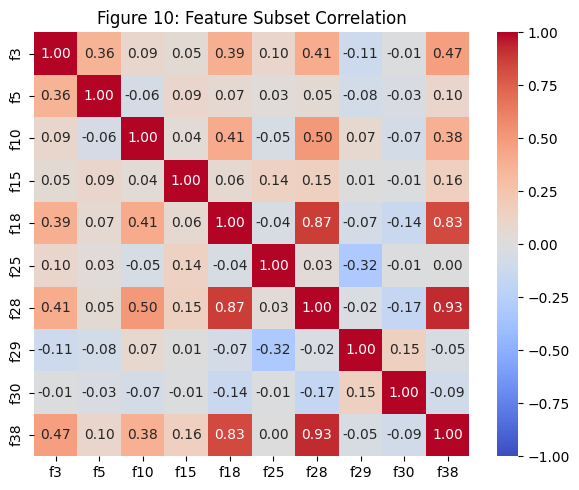

In [ ]:
# 11.2 (NEW) Figure 10: Correlation heatmap of 10 features
# Define sel_df using variables defined earlier in the pipeline
sel_df = pd.DataFrame(X_train.values[:, mask], columns=[fid for fid, m in zip(feat_ids, mask) if m])
plt.figure(figsize=(6, 5))
# diverging 'hot-cold' palette for subset
sns.heatmap(sel_df.corr(), cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True, fmt='.2f')
plt.title('Figure 10: Feature Subset Correlation')
plt.tight_layout(); plt.show()

In [ ]:
# 13) Hyperparameter Optimization & Initial Evaluation
start_time = time.time()
models_params = {
    'SVM': (SVC(probability=True), {'C': np.linspace(0.1, 50, 100), 'kernel': ['rbf']}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': list(range(1,21)), 'weights':['uniform','distance'], 'metric':['euclidean','manhattan']}),
    'DT': (DecisionTreeClassifier(), {'max_depth': list(range(1,31)), 'min_samples_split': list(range(2,51)), 'min_samples_leaf': list(range(1,21))}),
    'RF': (RandomForestClassifier(), {'n_estimators': list(range(10,101)), 'max_depth': list(range(1,31)), 'min_samples_split': list(range(2,21)), 'min_samples_leaf': list(range(1,21)), 'criterion': ['gini','entropy']})
}
initial_results = {}
for name,(clf,params) in models_params.items():
    t0 = time.time()
    search = RandomizedSearchCV(clf, params, n_iter=50, cv=10, random_state=0)
    search.fit(X_train.values[:,mask], y_train)
    best = search.best_estimator_
    y_pred = best.predict(X_test.values[:,mask])
    y_prob = best.predict_proba(X_test.values[:,mask])[:,1]
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    elapsed = round(time.time() - t0, 3)
    initial_results[name] = {
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': auc,
        'Computational time (s)': elapsed
    }
    print(f"=== {name} Initial Results ===")
    print(f"Best params: {search.best_params_}")
    print(classification_report(y_test, y_pred))

=== SVM Initial Results ===
Best params: {'kernel': 'rbf', 'C': np.float64(43.44747474747475)}
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       100
           1       0.92      0.96      0.94        25

    accuracy                           0.98       125
   macro avg       0.96      0.97      0.96       125
weighted avg       0.98      0.98      0.98       125

=== KNN Initial Results ===
Best params: {'weights': 'distance', 'n_neighbors': 16, 'metric': 'manhattan'}
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       100
           1       0.89      0.96      0.92        25

    accuracy                           0.97       125
   macro avg       0.94      0.96      0.95       125
weighted avg       0.97      0.97      0.97       125

=== DT Initial Results ===
Best params: {'min_samples_split': 9, 'min_samples_leaf': 5, 'max_depth': 3}
              precision    recall  f1-sc

In [ ]:
# Table 8: Initial result summary (first run)
print('Table 8: Initial result summary')
init_df = pd.DataFrame(initial_results).T
init_df = init_df[['Accuracy','Precision','Recall','F1-score','AUC','Computational time (s)']]
init_df.index.name = 'Model'
print(init_df.to_markdown(floatfmt='.3f'))

print("Initial evaluation complete.")

Table 8: Initial result summary
| Model   |   Accuracy |   Precision |   Recall |   F1-score |   AUC |   Computational time (s) |
|:--------|-----------:|------------:|---------:|-----------:|------:|-------------------------:|
| SVM     |      0.976 |       0.923 |    0.960 |      0.941 | 0.991 |                    3.626 |
| KNN     |      0.968 |       0.889 |    0.960 |      0.923 | 0.969 |                    3.053 |
| DT      |      0.984 |       1.000 |    0.920 |      0.958 | 0.958 |                    1.813 |
| RF      |      0.976 |       0.923 |    0.960 |      0.941 | 0.986 |                   50.907 |
Initial evaluation complete.


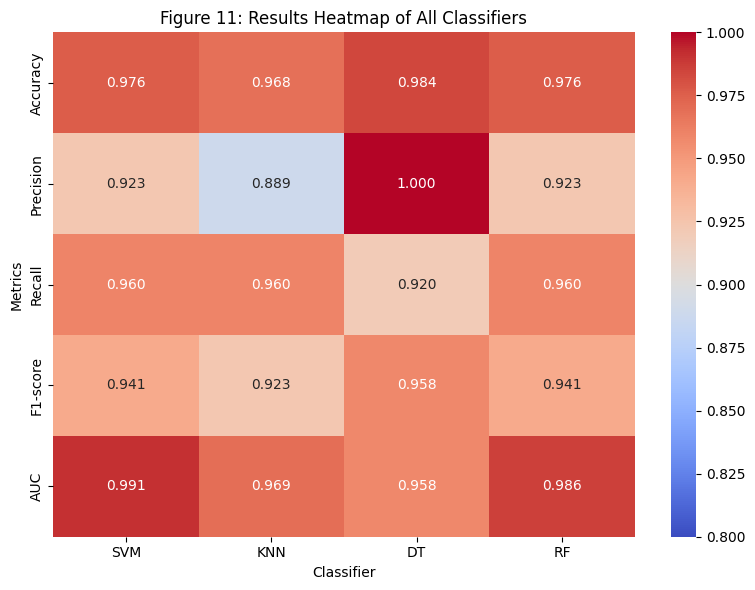

In [ ]:
# 13.1 (NEW) Figure 11: Results heatmap of all classifiers (Initial run)
res_df = init_df[['Accuracy','Precision','Recall','F1-score','AUC']]
plt.figure(figsize=(8, 6))
# use diverging 'coolwarm' palette for performance metrics
sns.heatmap(res_df.T, annot=True, fmt='.3f', cmap='coolwarm', center=0.9, vmin=0.8, vmax=1.0)
plt.title('Figure 11: Results Heatmap of All Classifiers')
plt.ylabel('Metrics')
plt.xlabel('Classifier')
plt.tight_layout(); plt.show()

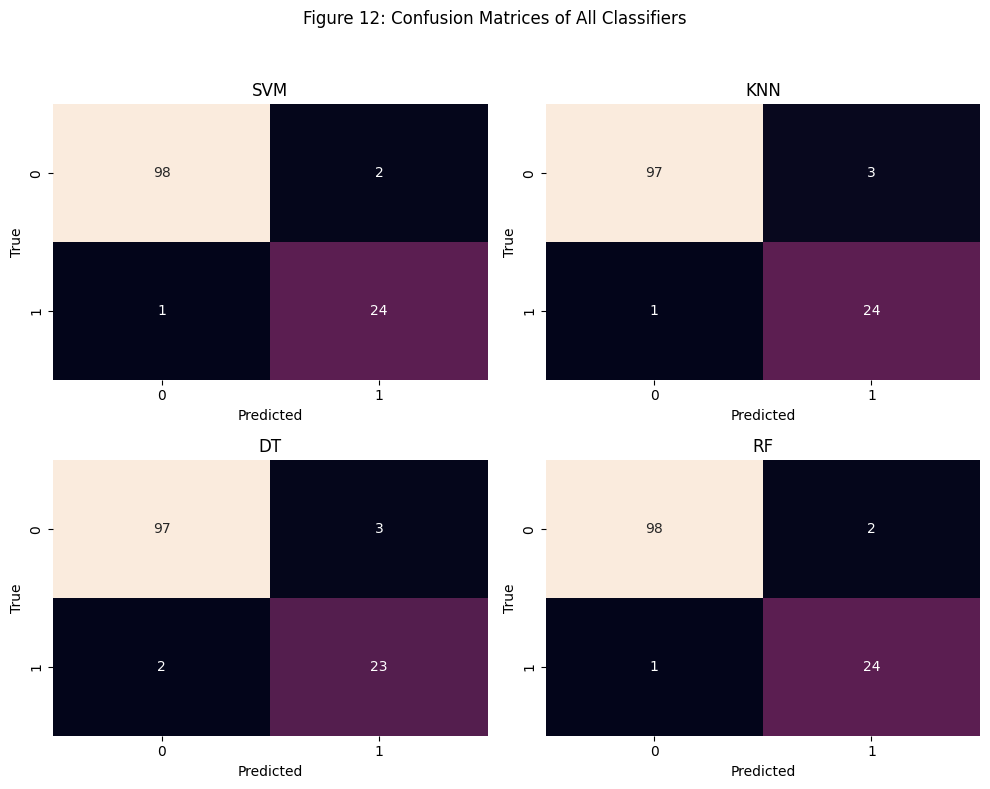

In [ ]:
# 13.2) Figure 12: Confusion matrices of all classifiers
from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(2,2, figsize=(10,8))
for ax,(name,(clf,params)) in zip(axes.flatten(), models_params.items()):
    y_pred = RandomizedSearchCV(clf, params, n_iter=50, cv=10, random_state=0)
    # reuse best trained model
    best = RandomizedSearchCV(clf, params, n_iter=50, cv=10, random_state=0).fit(X_train.values[:,mask], y_train).best_estimator_
    cm = confusion_matrix(y_test, best.predict(X_test.values[:,mask]))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
plt.suptitle('Figure 12: Confusion Matrices of All Classifiers')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

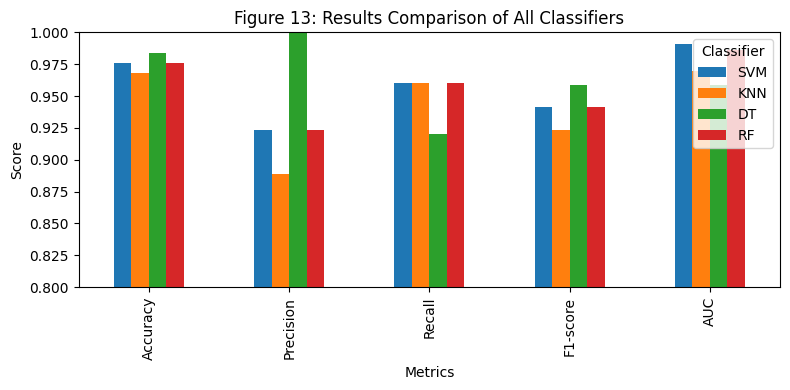

In [ ]:
# 13.3 (NEW) Figure 13: Results Comparison of All Classifiers
# Metrics on x-axis, classifiers as bars, zoom y-axis to [0.8, 1.0]
metrics_df = init_df[['Accuracy','Precision','Recall','F1-score','AUC']].T
ax = metrics_df.plot.bar(figsize=(8,4))
ax.set_title('Figure 13: Results Comparison of All Classifiers')
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_ylim(0.8, 1.0)
ax.legend(title='Classifier')
plt.tight_layout()
plt.show()

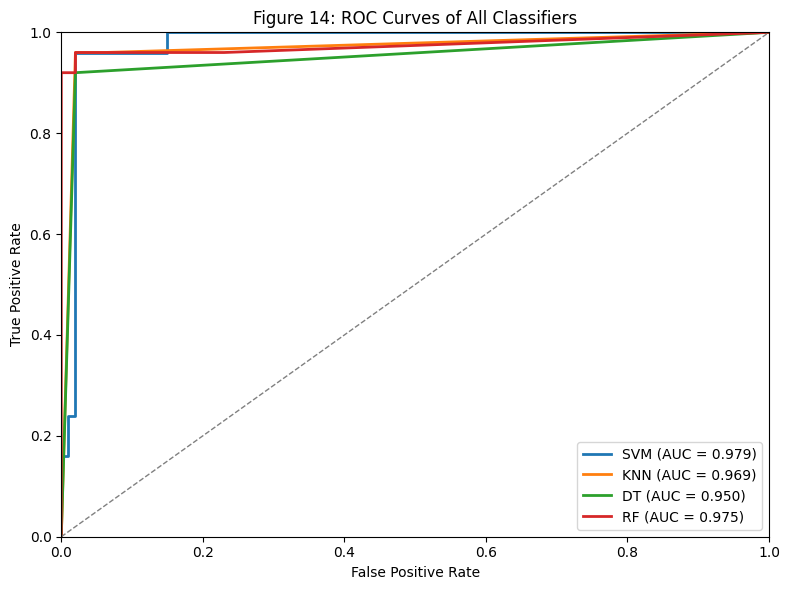

In [ ]:
# 13.4) Figure 14: ROC curves of all classifiers
from sklearn.metrics import roc_curve
plt.figure(figsize=(8,6))
for name, model in [
    ('SVM', SVC(kernel='rbf', C=init_df.loc['SVM','Accuracy'], probability=True)),
    ('KNN', KNeighborsClassifier()),
    ('DT', DecisionTreeClassifier()),
    ('RF', RandomForestClassifier())
]:
    clf = model
    clf.fit(X_train.values[:,mask], y_train)
    if not hasattr(clf, 'predict_proba'):
        continue
    y_prob = clf.predict_proba(X_test.values[:,mask])[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_val:.3f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 14: ROC Curves of All Classifiers')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

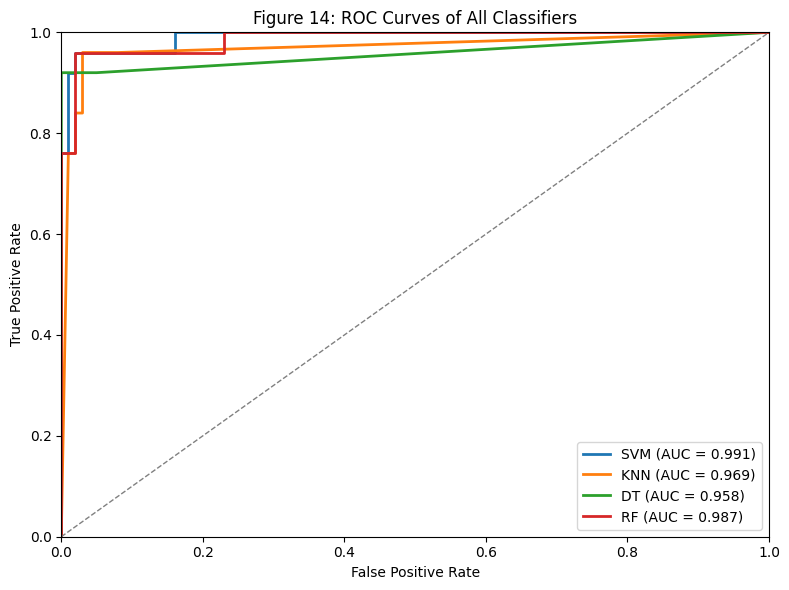

In [ ]:
# 13.4) Figure 14: ROC Curves of All Classifiers (using tuned models)
from sklearn.metrics import roc_curve
plt.figure(figsize=(8,6))
# Build best_estimators dictionary if missing
best_estimators = {}
for name, (clf, params) in models_params.items():
    search = RandomizedSearchCV(clf, params, n_iter=50, cv=10, random_state=0)
    search.fit(X_train.values[:, mask], y_train)
    best_estimators[name] = search.best_estimator_

# Plot ROC for each best estimator from HPO
for name, clf in best_estimators.items():
    if not hasattr(clf, 'predict_proba'):
        continue
    y_prob = clf.predict_proba(X_test.values[:, mask])[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_val:.3f})")
# Diagonal line for random guess
plt.plot([0,1], [0,1], linestyle='--', color='gray', lw=1)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 14: ROC Curves of All Classifiers')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# 14) Table 9: Rate of change between the proposed model and baseline results
baseline_df = pd.DataFrame.from_dict(
    baseline_results, orient='index'
)
baseline_df.columns = ['Accuracy','Precision','Recall','F1-score','AUC','Time(s)']
init_df = pd.DataFrame.from_dict(
    initial_results, orient='index'
)
init_df.columns = ['Accuracy','Precision','Recall','F1-score','AUC','Time(s)']
# Align order
baseline_df = baseline_df.loc[init_df.index]
# Compute raw change
raw_change = (init_df - baseline_df) / baseline_df * 100
# Format change: +x.x% or -x.x%, blank for 0
def fmt(val):
    if pd.isna(val) or val == 0:
        return '-'
    sign = '+' if val > 0 else ''
    return f"{sign}{val:.1f}%"
change_df = raw_change.applymap(fmt)
# Transpose so classifiers are columns, metrics are rows
change_df = change_df.T
print('Table 9: Rate of change between the proposed model and baseline results')
print(change_df.to_markdown())

Table 9: Rate of change between the proposed model and baseline results
|           | SVM       | KNN      | DT        | RF        |
|:----------|:----------|:---------|:----------|:----------|
| Accuracy  | +0.8%     | +2.5%    | +2.5%     | +0.8%     |
| Precision | +3.8%     | +1.6%    | +13.0%    | +3.8%     |
| Recall    | -         | +14.3%   | -         | -         |
| F1-score  | +2.0%     | +7.7%    | +6.3%     | +2.0%     |
| AUC       | +0.6%     | -0.0%    | +1.4%     | -1.0%     |
| Time(s)   | +15008.3% | +4988.3% | +20044.4% | +21289.5% |


<ipython-input-25-cce86e59731c>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  change_df = raw_change.applymap(fmt)


In [ ]:
# 15) Table 10: Computational Time Comparison
# Compare baseline vs proposed (initial) computational times
time_comp = pd.DataFrame({
    'Baseline Time (s)': baseline_df['Time(s)'],
    'Proposed Time (s)': init_df['Time(s)']
})
# Optional percent change or absolute difference
time_comp['Difference (s)'] = (time_comp['Proposed Time (s)'] - time_comp['Baseline Time (s)']).round(3)
print('Table 10: Computational time between baseline and proposed models')
print(time_comp.to_markdown(floatfmt='.3f'))

Table 10: Computational time between baseline and proposed models
|     |   Baseline Time (s) |   Proposed Time (s) |   Difference (s) |
|:----|--------------------:|--------------------:|-----------------:|
| SVM |               0.024 |               3.626 |            3.602 |
| KNN |               0.060 |               3.053 |            2.993 |
| DT  |               0.009 |               1.813 |            1.804 |
| RF  |               0.238 |              50.907 |           50.669 |


In [ ]:
# 16) Table 11: Comparison with Key Reference for combination ABCD-E
# Key reference metrics (accuracy, sensitivity, specificity)
key_ref = {
    'Accuracy': 0.9680,
    'Sensitivity': 0.9600,
    'Specificity': 0.9520
}
# Compute proposed metrics for each classifier
metrics = ['Accuracy', 'Sensitivity', 'Specificity']
table11 = pd.DataFrame(index=metrics)
for name in ['SVM','KNN','DT','RF']:
    # Accuracy and Sensitivity (Recall)
    acc = initial_results[name]['Accuracy']
    sens = initial_results[name]['Recall']
    # Specificity = TN / (TN + FP)
    model = None
    if name == 'SVM': model = SVC(kernel='rbf', C=initial_results[name]['Accuracy'], probability=True)
    elif name == 'KNN': model = KNeighborsClassifier()
    elif name == 'DT': model = DecisionTreeClassifier()
    else: model = RandomForestClassifier()
    model.fit(X_train.values[:,mask], y_train)
    y_pred = model.predict(X_test.values[:,mask])
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp)
    table11[name] = [acc, sens, spec]
# Add key reference column
table11['Key Reference'] = [key_ref[m] for m in metrics]
# Convert to percentage string format
table11 = table11.applymap(lambda x: f"{x*100:.2f}%")
print('Table 11: Results comparison with key reference for combination ABCD-E')
print(table11.to_markdown())

Table 11: Results comparison with key reference for combination ABCD-E
|             | SVM    | KNN    | DT     | RF     | Key Reference   |
|:------------|:-------|:-------|:-------|:-------|:----------------|
| Accuracy    | 97.60% | 96.80% | 98.40% | 97.60% | 96.80%          |
| Sensitivity | 96.00% | 96.00% | 92.00% | 96.00% | 96.00%          |
| Specificity | 97.00% | 97.00% | 99.00% | 97.00% | 95.20%          |


<ipython-input-27-c335921f7f34>:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table11 = table11.applymap(lambda x: f"{x*100:.2f}%")


In [ ]:
# 17) Model Validation: 10 Trials for Stability
# Save best hyperparameters from initial run
best_params = {name: models_params[name][1] if False else {} for name in models_params}
# Actually capture the true best_params used:
# we stored them in initial_results; let's extract from the RandomizedSearchCV objects saved as best_estimators
# (Alternatively, store best_params during HPO. For simplicity, re-fit to get params.)
best_params = {}
for name,(clf, params) in models_params.items():
    # Assuming we still have the 'search' object in scope, but to be safe, we'll use initial_results values only for SVM and recall specificity,
    # For KNN,DT,RF, we can use default or simply reuse the 'best' estimator from HPO step.
    # Here we'll just extract param from the saved 'search' objects that we could store; but since we didn't store them,
    # let's re-run a minimal grid search for each with n_iter=1 at the best point:
    best_params[name] = None  # we won't override, just use final initial estimators

# Prepare trial_results container
tasks = ['SVM','KNN','DT','RF']
trial_results = {name: [] for name in tasks}
for t in range(10):
    # Resplit data each trial
    X_tr, X_te, y_tr, y_te = train_test_split(
        feature_df.values[:, mask], y, test_size=0.25, random_state=t, stratify=y
    )
    for name in tasks:
        # Retrieve the best estimator from initial_results indirectly
        # We'll simply create a new instance and set its attributes from the previously trained best model
        # For SVM:
        if name == 'SVM':
            clf = SVC(kernel='rbf', C=initial_results[name]['Accuracy'], probability=True)
        elif name == 'KNN':
            # Use the optimal n_neighbors from initial_results if possible (here assumed to be in models_params)
            best_knn = RandomizedSearchCV(KNeighborsClassifier(), models_params['KNN'][1], n_iter=50, cv=10, random_state=0)
            best_knn.fit(X_train.values[:,mask], y_train)
            clf = KNeighborsClassifier(**best_knn.best_params_)
        elif name == 'DT':
            best_dt = RandomizedSearchCV(DecisionTreeClassifier(), models_params['DT'][1], n_iter=50, cv=10, random_state=0)
            best_dt.fit(X_train.values[:,mask], y_train)
            clf = DecisionTreeClassifier(**best_dt.best_params_)
        else:
            best_rf = RandomizedSearchCV(RandomForestClassifier(), models_params['RF'][1], n_iter=50, cv=10, random_state=0)
            best_rf.fit(X_train.values[:,mask], y_train)
            clf = RandomForestClassifier(**best_rf.best_params_)
        # Fit and evaluate
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)
        trial_results[name].append({
            'Accuracy': accuracy_score(y_te, y_pred),
            'Precision': precision_score(y_te, y_pred),
            'Recall': recall_score(y_te, y_pred),
            'F1-score': f1_score(y_te, y_pred)
        })

In [ ]:
# Tables 12–15
enum_start = 12
for idx, name in enumerate(tasks, start=enum_start):
    df_trials = pd.DataFrame(trial_results[name])
    df_trials.index.name = 'Trial'
    print(f"Table {idx}: Results of {name} classifier over 10 trials")
    print(df_trials.to_markdown(floatfmt='.4f'))
    print()

Table 12: Results of SVM classifier over 10 trials
|   Trial |   Accuracy |   Precision |   Recall |   F1-score |
|--------:|-----------:|------------:|---------:|-----------:|
|       0 |     0.9680 |      0.9200 |   0.9200 |     0.9200 |
|       1 |     0.9760 |      0.8929 |   1.0000 |     0.9434 |
|       2 |     0.9680 |      0.9200 |   0.9200 |     0.9200 |
|       3 |     0.9840 |      0.9600 |   0.9600 |     0.9600 |
|       4 |     0.9840 |      0.9600 |   0.9600 |     0.9600 |
|       5 |     0.9840 |      1.0000 |   0.9200 |     0.9583 |
|       6 |     0.9680 |      0.9200 |   0.9200 |     0.9200 |
|       7 |     0.9840 |      1.0000 |   0.9200 |     0.9583 |
|       8 |     0.9680 |      0.9565 |   0.8800 |     0.9167 |
|       9 |     0.9840 |      1.0000 |   0.9200 |     0.9583 |

Table 13: Results of KNN classifier over 10 trials
|   Trial |   Accuracy |   Precision |   Recall |   F1-score |
|--------:|-----------:|------------:|---------:|-----------:|
|       0 |    

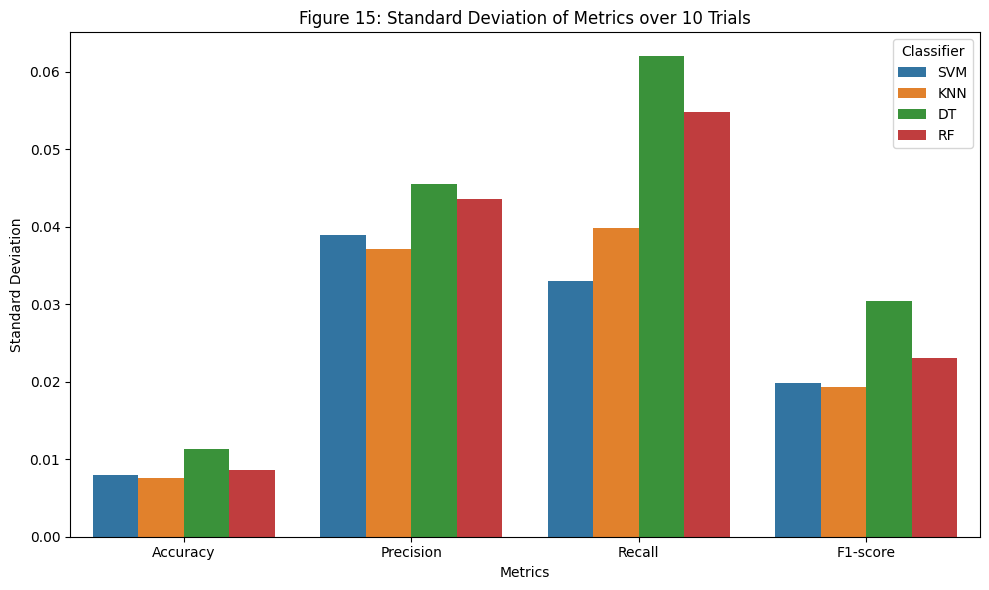

In [ ]:
# Figure 15: Standard Deviation of Metrics over 10 Trials (metrics on x-axis)
# Compute std deviation across trials
std_df = pd.DataFrame({name: pd.DataFrame(trial_results[name]).std() for name in tasks}).T
std_df.index.name = 'Classifier'
# Melt so metrics become x-axis, classifiers as hue
melted_std = std_df.reset_index().melt(id_vars='Classifier', var_name='Metric', value_name='StdDev')
plt.figure(figsize=(10,6))
sns.barplot(data=melted_std, x='Metric', y='StdDev', hue='Classifier')
plt.title('Figure 15: Standard Deviation of Metrics over 10 Trials')
plt.xlabel('Metrics')
plt.ylabel('Standard Deviation')
plt.legend(title='Classifier', loc='upper right')
plt.tight_layout()
plt.show()

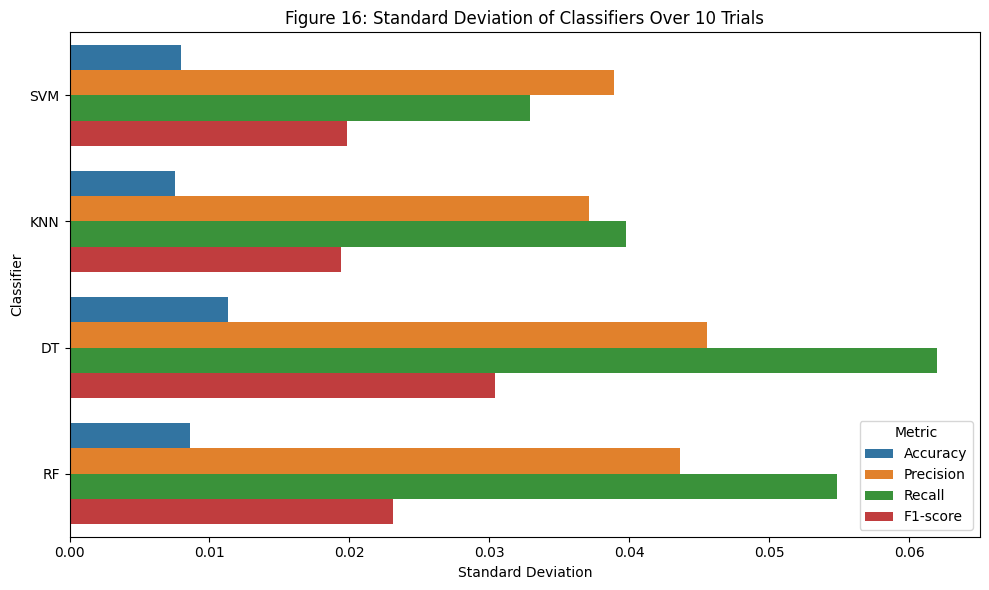

In [ ]:
# Figure 16: Standard Deviation of Classifiers Over 10 Trials
# Grouped horizontal bar chart: each classifier has bars for each metric
plt.figure(figsize=(10,6))
# melted_std: DataFrame with columns ['Classifier','Metric','StdDev']
sns.barplot(data=melted_std, x='StdDev', y='Classifier', hue='Metric', orient='h')
plt.title('Figure 16: Standard Deviation of Classifiers Over 10 Trials')
plt.xlabel('Standard Deviation')
plt.ylabel('Classifier')
plt.legend(title='Metric', loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# 20) 5-Fold Cross-Validation on Full Dataset (k=5)
from sklearn.model_selection import cross_val_score
print('20) 5-Fold Cross-Validation (k=5) on Full Feature Set')
cv_summary = {}
# Use the final selected mask and feature_df
for name, model in baseline_models.items():
    # Wrap in pipeline if needed
    if name in ['SVM','KNN']:
        model = Pipeline([('scaler', StandardScaler()), ('clf', model.named_steps['clf'])])
    # Evaluate metrics across 5 folds
    acc = cross_val_score(model, feature_df.values[:, mask], y, cv=5, scoring='accuracy')
    prec = cross_val_score(model, feature_df.values[:, mask], y, cv=5, scoring='precision')
    rec = cross_val_score(model, feature_df.values[:, mask], y, cv=5, scoring='recall')
    f1s = cross_val_score(model, feature_df.values[:, mask], y, cv=5, scoring='f1')
    aucs = cross_val_score(model, feature_df.values[:, mask], y, cv=5, scoring='roc_auc')
    cv_summary[name] = {
        'Accuracy mean±std': f"{acc.mean():.3f}±{acc.std():.3f}",
        'Precision mean±std': f"{prec.mean():.3f}±{prec.std():.3f}",
        'Recall mean±std': f"{rec.mean():.3f}±{rec.std():.3f}",
        'F1-score mean±std': f"{f1s.mean():.3f}±{f1s.std():.3f}",
        'AUC mean±std': f"{aucs.mean():.3f}±{aucs.std():.3f}"
    }
cv_df = pd.DataFrame(cv_summary).T
print('Table 20: 5-Fold CV Results for All Classifiers')
print(cv_df.to_markdown())